In [2]:
import pandas as pd
import numpy as np
import gzip
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# Toggle on-off code text  
from IPython.display import HTML

df_listings = pd.read_csv('singapore_listings_20190318.csv', low_memory=True).drop(columns='Unnamed: 0')

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()">
# <input type="submit" value="Click to toggle on/off the raw code.">
# </form>''')

C:\Users\Ralph Palomaria\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<img src="./sg.jpg" height=500 width=1000>

# AirBnB @ Singapore: Exploring Traveller Segments in SG

## 1 Executive Summary

This part should include the following:
- summary 
- convincing motivation for the study
- methodoloy
    - data source, description and preprocessing pipeline
    - clustering method
    - validation methtods
    - selection of best k
- results
- conclusion and recommendation

## 2 Introduction

In this part include the following:
- why cluster air bnb listings?
- what is the main problem statement
- use cases on customer segmentation
- expound on the motivation
- what is the business value?
- What do we want to answer in this study?
- scope and limitations
- assumptions

## 3 Data Scope and Description

In this part, perform summary statistics to describe the data.
- scope of data
- summary statistics per features
- data types: nominal, categorial, ordinal, numerical
- what are the features present in the data set
- description of each feature
- how many instances are there?
- what is the relevance of each feature?
- data source

In [68]:
## selection of relevant features

data = df_listings[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
            'bed_type', 'amenities', 'price', 'minimum_nights', 
            'instant_bookable',
            'neighborhood_overview']].copy()

## 4 Imputation, Outliers, and Multivariate Data Analysis

Most features contain missing values, outliers, and wrong inputs (like typographical error). To address this, the following methodologies were applied for handling of outliers, treatment of missing values, imputation and converting some values of features into proper form. This section is divided into the following:

- **4.1** Converting values of features into Proper Form
- **4.2** Treatment of Missing Values
- **4.3** Handling of Outliers

### 4.1 Converting Values of Features into Proper Form

The type and subtypes of each feature are shown in Table  N.n below. Most of the categorrical features can be converted into desired subtype by one-hot encoding. The categorical-nominal features `property_type`, `room_type`, `bed_type`, and `instant_bookable` will be on-hot encoded in subsequent sections. On the other hand, `amenities` and `neighborhood_overview` will be vectorized before on-hot encoding. For numerical features, the '`price` is given as `str` object. Thus, it must be stripped and converted as `float` object instead. Other numerical features `accomodates`, `bedrooms`, `beds` and `minimum_nights` will not be changed.

| Data | Feature Type | Subtype |
| ---- | --------- | ------ |
| `property_type` | Categorical | Nominal |
| `room_type` | Categorical | Nominal |
| `accomodates` | Numerical | Discrete |
| `bathrooms` | Numerical | Discrete |
| `bedrooms` | Numerical | Discrete |
| `beds` | Numerical | Discrete |
| `bed_type` | Categorical | Nominal |
| `amenities` | Categorical | Nominal |
| `price` | Numerical | Continuous |
| `minimum_nights` | Numerical | Discrete |
| `instant_bookable` | Categorical | Nominal |
| `neighborhood_overview` | Categorical | Nominal |

In [69]:
## concert price into float

def convert(x):
    """Converts the values under the feature `price` into `float`.
    """
    try:
        return int(x.strip('$').split('.')[0].split(',')[0])*1000+int(x.strip('$').split('.')[0].split(',')[1])
    except IndexError:
        return int(x.strip('$').split('.')[0])

data['price'] = data['price'].apply(lambda x: convert(x))

### 4.2 Treatment of Missing Values

The following features shown in Table N.n have missing values. The number of missing are also given in the first column. The type of imputation or handling, and the expected error for each is discussed below. The features `bathrooms`, `bedrooms` and `beds` are all numerical-discrete types, while the feature `neghborhood_overview` is given as string or text description. The `neighborhood_overview` will be vectorized in the subsequent section, then it will be one-hot encoded. 

In [70]:
na = data.isna().sum()[data.isna().sum()>0].to_frame()
na.columns = ['Number of Missing Values']
display(na)

,Number of Missing Values
bathrooms,6
bedrooms,6
beds,15
neighborhood_overview,3234


*Feature: Bathroom*<br><br>
From Figure N.n, more than **70%** of the values of the feature_bathroom is **1**, having **5000** occurances. The next most frequent value is **2** with **1500** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **6** missing values, the maximum possible error due to this imputation would only be **<0.1%**.

*Feature: bedrooms*<br><br>
From Figure N.n, more than **60%** of the values of the feature_bedhroom is **1**, having **5000** occurances. The next most frequent value is **2** with **1400** occurances. The third and fourth most frequent values are **0** and **3**, with **<1000** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **6** missing values, the maximum possible error due to this imputation would only be **<0.1%**.

*Feature: beds*<br><br>
From Figure N.n, more than **50%** of the values of the feature_bedhroom is **1**, having **4500** occurances. The next most frequent value is **2** with **1800** occurances. The third and fourth most frequent values are **3** and **4**, with **<1000** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **15** missing values, the maximum possible error due to this imputation would only be **<0.2%**.

*Feature: Neighborhood Overview*<br><br>
The  values under the neighborhood overview are the descriptions in text form. Thus, missing values would not be imputed by any method. Instead, missing values were replaced by empty sring `""` to be consistent with the data type of other values under this feature.

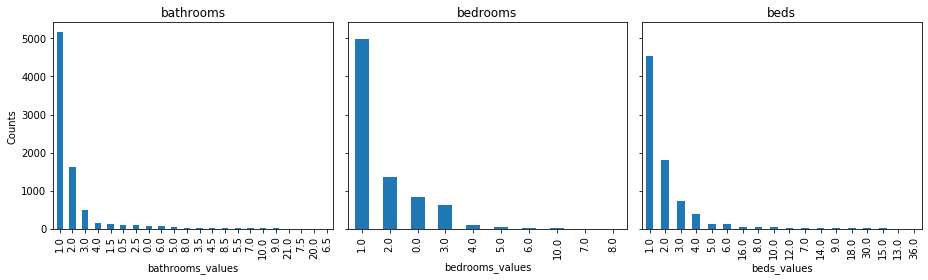

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
data['bathrooms'].value_counts().plot(kind='bar', ax=ax1)
data['bathrooms'].fillna(data['bathrooms'].value_counts().index[0], inplace=True)
data['bedrooms'].value_counts().plot(kind='bar', ax=ax2)
data['bedrooms'].fillna(data['bedrooms'].value_counts().index[0], inplace=True)
data['beds'].value_counts().plot(kind='bar', ax=ax3)
data['beds'].fillna(data['beds'].value_counts().index[0], inplace=True)

ax1.set_title('bathrooms')
ax2.set_title('bedrooms')
ax3.set_title('beds')

ax1.set_ylabel('Counts')
ax1.set_xlabel('bathrooms_values')
ax2.set_xlabel('bedrooms_values')
ax3.set_xlabel('beds_values')

plt.tight_layout()
data['neighborhood_overview'].fillna('', inplace=True)

### 4.3 Handling of Outliers

Float values were observed under the feature `bathrooms`. The feature should contain only counting numbers but decimals were observed such as 1.5, 0.5, 8.5, etc. Thus, floating values will be rounded up to the nearest integer. 

For the numerical features, the boxplots are given by Figure N.n. The features `accomodates`, and `bedrooms` have relativelygood distribution with very few data points lying above the upper quartile. On the other hand, the features `bathrooms`, `beds` and `minimum_nights` shows some significant number of outliers - these outliers are 2-3x greater than the upper quartile. For objectivity, Interquartile (IQR) method with 4.0 factor threshold was used to filter out the outliers on the extremities [B]. This means that values above 4x the IQR ($\text{IQR}_{75}-\text{IQR}_{25}$) will be removed. Using the IQR method, a total of 1,111 number of outliers were removed, which is around 14% of the dataset. For comparison, the boxplots of the numerical features after removing the outliers are shown in Figure N.n. Based on Figure N.n, most of the data on the upper extremities were removed.

In [72]:
print('Before: ', list(np.unique(data['bathrooms'])))
data['bathrooms'] = data['bathrooms'].transform(np.ceil)
print('After: ', list(np.unique(data['bathrooms'])))

Before:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 10.0, 20.0, 21.0]
After:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 21.0]


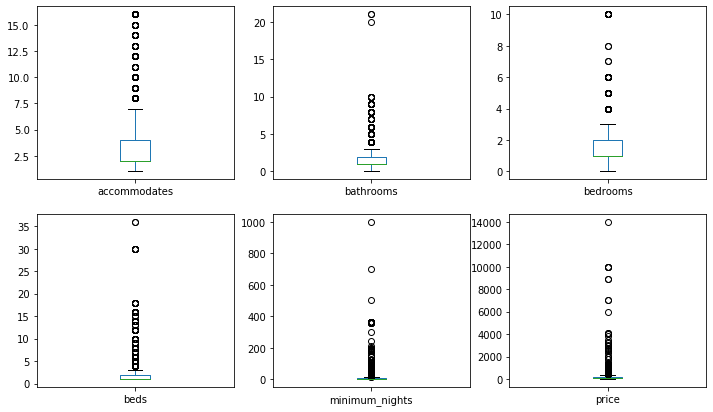

In [73]:
# list of numerical features - discrete and continuos
col_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'price']

# Draws the boxplt of each feature
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

In [74]:
print('Size before removing outliers: ', data.shape)

# Outlier Detection and Filtering Using IQR Method
for i in range(len(col_list)):
    # calculate interquartile range
    col_name25 = 'q25_' + col_list[i]
    data[col_name25] = np.percentile(data[col_list[i]], 25)

    col_name75 = 'q75_' + col_list[i]
    data[col_name75] = np.percentile(data[col_list[i]], 75)
    
    # calculate the outlier cutoff
    col_namecut = 'cut_' + col_list[i]
    data[col_namecut] = (data[col_name75] - data[col_name25])*4

    col_namelow = 'low_' + col_list[i]
    data[col_namelow] = data[col_name25] - data[col_namecut] 

    col_nameup = 'up_' + col_list[i]
    data[col_nameup] = data[col_name75] + data[col_namecut] 
    
    # identify outliers
    col_nameout = 'out_' + col_list[i]
    data[col_nameout] = (data[col_list[i]] < data[col_namelow])  | (data[col_list[i]] > data[col_nameup])
    
    # drop intermediate columns
    data.drop(columns=[col_name25, col_name75, col_namecut, col_namelow, col_nameup], inplace=True)

data['sum'] = data[['out_' + col_list[i] for i in range(len(col_list))]].sum(axis=1) > 0

# remove outliers
data = data.loc[~data['sum']].iloc[:, :-7].copy()

print('Size after removing outliers: ', data.shape)


Size before removing outliers:  (7975, 12)
Size after removing outliers:  (6864, 12)


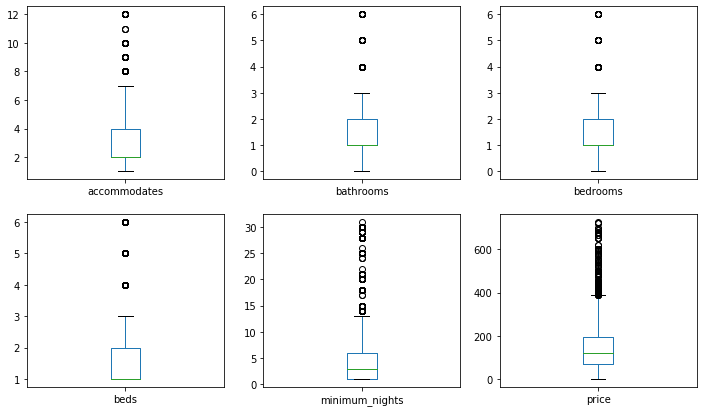

In [75]:
# Draws the boxplot after filtering the outliers
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

## 5 BiVariate Analysis

The heatmap presented in Figure N.n shows partial collinearities between the following features: `accommodates`, `bedrooms`, `bathrooms`, and `beds`. The strongest linear correlation was observed on beds vs acccomodates. As expected, these features would have some degree of collinearity since the capacity to acccomodate means more bedrooms and beds. In order to eliminate collinearities, variance inflation factors (VIF) were calculated. The VIF factor measure the increase in the variance of the parameter estimate if an additional variable is added to a linear regression. Thus, a high VIF factor is indicative of high degree of collinearity.

The highest VIF factor was obtained for the feature `accommodates` (Table N.n). Typically, a VIF of $>10$ indicates high collinearity. Thus, the feature `accommodates` will be removed from the dataset. The new calculated VIFs are now given in Table N.n.

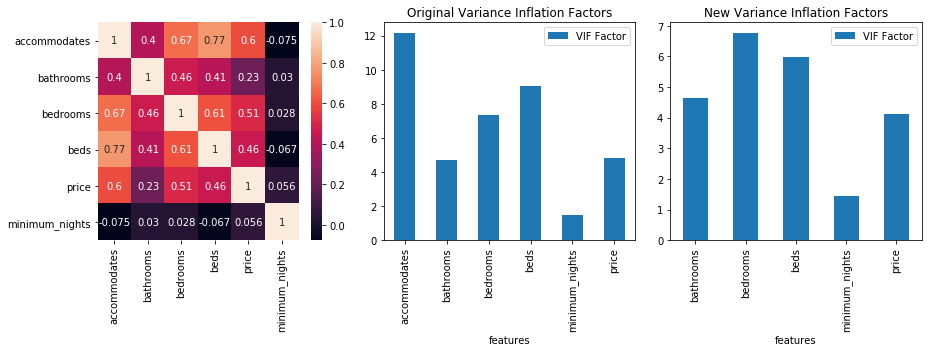

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,5))

# Draws the  correlation heatmap for numerical features
sns.heatmap(data.corr(), annot=True, ax=ax1)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_title('Correlation Heatmap for Numerical Features')

# Shows the Original Variance Inflation Factors
X =  data[col_list]
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.set_index('features').plot(kind='bar', ax=ax2)
ax2.set_title('Original Variance Inflation Factors')
# ax2.set_ylabel('Variance Inflation Factors (VIF)')

# Shows the VIF after Eliminating Collinearities
X =  data[col_list].drop(columns='accommodates')
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.set_index('features').plot(kind='bar', ax=ax3)
ax3.set_title('New Variance Inflation Factors')

plt.tight_layout()

data.drop(columns='accommodates', inplace=True)

## 6 Exploratory Data Analysis (Prior Clustering)

In [23]:
data.isna().sum().sum()

0

## 7 Feature Engineering

In preparation for clustering, features must be preprocessed, engineered, reduced, encoded and scaled. There are several advantages for doing so which includes but not limited to the following:<br>
**(1)** Feature engineering reduces the variance of the data, which in turn makes the clusters more defined and interpretable.<br>
**(2)** It reduces run-time exponentially.<br>
**(3)** Decreases the likelihood for curse of dimensionality.<br>

This section is divided into four (4) subsection listed below. The techniques applied for feature engineering are discussed in the subsequent subsections.

- **7.1** Vectorization of Categorical-Nominal Features
- **7.2** Logarithmic Transformantion for Numerical-Continuous Features
- **7.3** One-Hot Encoding for Nominal-Categorical Features
- **7.4** Dimensiionality Reduction by Singular Value Decomposition (SVD)

Feature mapping will not be done in this study since all categorical features are nominal subtype.

### 7.1 Vectorization of Categorical Features

The values under the feature `amenities` are given as string enclosed in braces `{`, `}`. Thus, in order to extract the relevant information, these values were stripped, tokenized and vectorized based on their respective frequencies (Bag-of-Words representation). Irrelevant tokens such as `in`, `of` and the likes were removed to reduce the size of the resuting dataset, NaN values were replaced by 0. This vectorization resulted to additional 195 columns in the data frame.

The values under the feature `neighborhood_overview` are also given as list of strings. Thus, the same method was employed to extract the relevant information. That is, the values were stripped, tokenized and vectorized based on their respecttive frequencies. Similarly, irrelevant tokens were removed to reduce the resulting size of the dataset. NaN values were replaced by 0. This vectorization resulted to additional 180 columns in the data frame.

In [30]:
## vectorize amenities

irr_words = ['the', 'and', 'to', 'of', 'in', 'is', 'a', 'from', 'for', '-', 
             'are', 'at', 'etc', 'or', '&', 'that', 'will', 'an', 'with', 
             'as', '2', 'it', 'premises', 'allowed', 'be', 'head', 'on', 
             'tanjong', 'can', 'located', 'just', 'not', 'min', 'tiong', 
             'many', 'within', 'first', 'self', 'by', 'there', 'we', 
             'on', 'check', 'about', 'out', 'bharu', 'translation', 'you', '/', 'off']

irr_words_col = ['amenities_' + word for word in irr_words] + ['amenities']

def to_bow(docs):
    my_list = [dict(Counter(doc.lower().split())) for doc in docs]
    df = pd.DataFrame(my_list).fillna(0)
    return df.reindex(sorted(df.columns), axis=1)

stripped = [string.strip('{').strip('}').split(',') for string in list(data['amenities'].values)]

stripped_list = []
for group in stripped:
        stripped_list.append([word.strip('''"''').strip("'") for word in group])
        
bow_list_amenities = []
for group in stripped_list:
    bow_list_amenities.append(to_bow(group).sum())
    
cat_amenities = pd.concat(bow_list_amenities, axis=1).fillna(0)
cat_amenities = cat_amenities.T.copy()
cat_amenities.columns = ['amenities_'+name for name in cat_amenities.columns.to_list()]
data1 = pd.concat([data.reset_index(drop=True), cat_amenities.reset_index(drop=True)], axis=1)

for col in irr_words_col:
    try:
        data1.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [31]:
## vectorize neighborhood overview
irr_words_col_neigh = ['neighborhood_overview_' + word for word in irr_words] + ['neighborhood_overview']

stripped_neigh = data1['neighborhood_overview'].to_list()

text_list = [text.split(' ') for text in stripped_neigh]

group_list = []
for group in text_list:
    group_list.append([word.strip().strip("'").strip('''"''').strip('.').strip('(').strip(')').strip('!') for word in group])

bow_list_neigh = []
for group in group_list:
    bow_list_neigh.append(to_bow(group).sum())
    
cat_neigh = pd.concat(bow_list_neigh, axis=1).T.fillna(0)

cat_neigh.columns = ['neighborhood_overview_'+name for name in cat_neigh.columns.to_list()]
data2 = pd.concat([data1.reset_index(drop=True), cat_neigh.reset_index(drop=True)], axis=1)
for col in irr_words_col_neigh:
    try:
        data2.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [ ]:
# data2.columns.to_list()

**Log Transformation**

Some features are highly skewed as observed in the multivariate analysis. In these features, logarithmic transformation was used to reduce the variable and make the data more conforming to normal distribution [B]. The transformation takes the form

$$
f(x) = \log{(x+1)}
$$

Based on the density plots, the dsitribution became closer to normal distribution after log-transformation.

*Figure N.n Comparison of Density Plots Before and After Log Transformation*

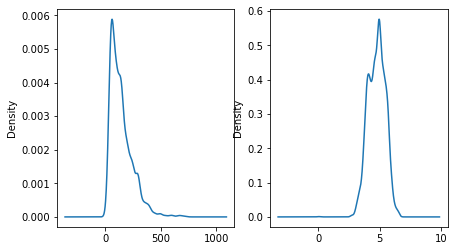

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
data2['price'].plot(kind='density', ax=ax1)
data2['log_price'] = (data2['price'] + 1).transform(np.log)
data2.drop(columns='price', inplace=True)
data2['log_price'].plot(kind='density', ax=ax2)

**One-Hot Encode Nominal Categorical Features**

The nominal categorical features such as `property_type`, `room_type`, `bed_type`and `instant_bookable` were one-hot encoded and the last column was dropped to reduce the number of dimensions. This would not result to information loss since for one-hot encoding, there is at least one feature that is lineary dependent to the rest of the features. 

In [33]:
## one-hot encode nominal categorical features
cols = [col + '_' + data2[col].unique()[0] for col in ['property_type', 'room_type', 'bed_type', 'instant_bookable']]
X = pd.get_dummies(data2).drop(columns=cols)

**Numerical Features Scaling by Standization**

Numerical features such as 'log_price', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights' will be scaled by standardization. The advantage of standardizing these features is to align orders of magnitude for distance computation in the clustering algorithm.

In [45]:
# numerical_features = ['log_price', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights']
# X_scaled = StandardScaler().fit_transform(X)

In [68]:
X.shape

(6864, 8959)

**Dimensionality Reduction by Singluar Value Decomposition**

It is imperative to reduce the number of dimensions in the dataset in order to select only the important features, especially for one-hot encoded Bag-of-Words representations of `neighborhood_overview` and `amenities`. This is useful to remove sub features of `neighborhood_overview` which only contains 1-2 instances in the whole data set. In addition, the number of features (8959) of the dataset is much greater than the number of objects (6864) which is very prone to the curse of dimensionality. 

Since the data contains oneh-hot encoded / sparse features, Singular Value Decomposition was used to reduce the number of features. As initial estimated, the ThresholdVariance set at 90% was used to estimated the resulting number of importance features. From the result of ThresholdVariance, the number of features was reduced from 8959 to 163. Hence, the data was truncated uby SVD using 163 components. The resulting plots of variances explained are show iin Figure N.n. Based from the plots, the first and most importance feature already explains the 35% of the total variance of the data. The second most important feature gives the 15%. From the cumulative plot, at 90% variance explain threshold, the estimated number of features is around 165. Thus, the initial estimated number of components was accurate.

In [ ]:
# set the variance threshold

p = 0.9
sel = VarianceThreshold(threshold=(p * (1 - p)))
X_reduced = sel.fit_transform(X.values)
print('Size before Variance Threshold reduction: ', X.values.shape)
print(f'Estimated size after {p*100}% Variance Threshold reduction: ', X_reduced.shape)

In [41]:
svd = TruncatedSVD(n_components=163).fit(X)
X_reduced = svd.transform(X)
explained_var = svd.explained_variance_
explained_var_ratio = svd.explained_variance_ratio_
s_values = svd.singular_values_

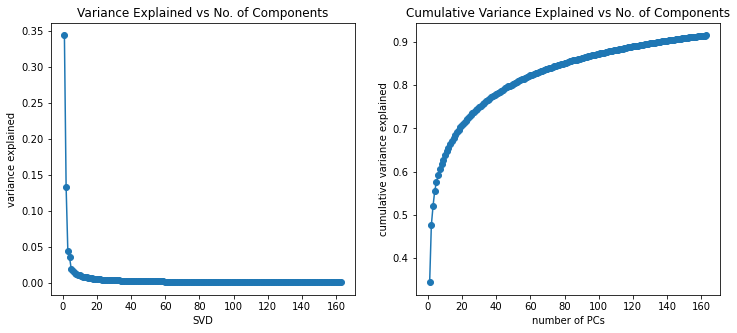

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, 'o-')
# ax1.set_ylim(0,1)
ax1.set_xlabel('SVD')
ax1.set_ylabel('variance explained')
ax1.set_title('Variance Explained vs No. of Components');

ax2.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio.cumsum(), 'o-')
# ax2.set_ylim(0,1)
ax2.set_xlabel('number of PCs')
ax2.set_ylabel('cumulative variance explained')
ax2.set_title('Cumulative Variance Explained vs No. of Components');

In [91]:
i = np.identity(X.shape[1])
weights = pd.DataFrame(svd.transform(i), index=X.columns)
weights.columns = [f'PC-{i+1}' for i in weights.columns]
np.abs(weights)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-154,PC-155,PC-156,PC-157,PC-158,PC-159,PC-160,PC-161,PC-162,PC-163
bathrooms,0.106220,0.170730,0.011191,0.088490,0.025234,0.142851,0.079798,0.152785,0.145666,0.163806,...,0.003347,0.011740,0.018349,0.018951,0.012995,0.018611,0.012202,0.006513,0.028886,0.027338
bedrooms,0.095688,0.160121,0.075707,0.035371,0.014105,0.157436,0.132157,0.137242,0.229205,0.176442,...,0.000658,0.015434,0.012740,0.019775,0.008481,0.033238,0.004875,0.006489,0.008170,0.016475
beds,0.124579,0.236795,0.085698,0.013707,0.052642,0.148266,0.176460,0.158264,0.394967,0.348451,...,0.004867,0.023621,0.016232,0.001568,0.002315,0.016169,0.002401,0.001272,0.004984,0.005005
minimum_nights,0.834329,0.537455,0.080841,0.029909,0.010004,0.026143,0.038622,0.000507,0.034222,0.023500,...,0.001421,0.000070,0.000692,0.001571,0.001565,0.000317,0.001800,0.001390,0.001004,0.002539
amenities_air,0.070726,0.109791,0.017098,0.023760,0.028856,0.011514,0.005898,0.004864,0.046525,0.067692,...,0.008624,0.035418,0.041620,0.006520,0.054183,0.004818,0.052963,0.064396,0.019476,0.031590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bed_type_Airbed,0.000017,0.000073,0.000108,0.000057,0.000100,0.000192,0.000006,0.000150,0.000006,0.000035,...,0.000251,0.000167,0.000308,0.000634,0.000378,0.000126,0.000555,0.000814,0.000727,0.000888
bed_type_Couch,0.000020,0.000094,0.000149,0.000089,0.000206,0.000268,0.000142,0.000167,0.000056,0.000444,...,0.000068,0.000258,0.001119,0.000325,0.000744,0.000436,0.001053,0.000506,0.000354,0.000598
bed_type_Futon,0.000090,0.000128,0.000276,0.000013,0.000403,0.000475,0.000331,0.000343,0.000031,0.001137,...,0.000084,0.000286,0.002181,0.003178,0.002613,0.001839,0.000707,0.000912,0.000346,0.000059
bed_type_Pull-out Sofa,0.000059,0.000171,0.000050,0.000260,0.000272,0.000331,0.000114,0.000293,0.000267,0.000862,...,0.000295,0.000278,0.000783,0.001479,0.002546,0.004365,0.004951,0.001072,0.000027,0.002247


## 7 Clustering

- clustering methods
- selection of best k
- validation

### 7.1 KMeans Clustering

In [71]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    Q_j = np.zeros(len(np.unique(y)))
    for index, cluster_i in enumerate(y):
        Qj_col = {v: k for k, v in enumerate(np.unique(y))}
        Q_j[Qj_col[cluster_i]] += dist(X[index, :], centroids[cluster_i, :])**2
    return sum(0.5*Q_j/np.unique(y, return_counts=True)[1])

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_ki = []
    for i in range(b):
        distribution = rng.uniform(X.min(0), X.max(0), X.shape)
        realizations = clusterer.fit_predict(distribution)
        W_ki.append(np.log(pooled_within_ssd(distribution, realizations, 
                                             clusterer.cluster_centers_, 
                                             dist)))
    E_logWk = np.mean(W_ki)
    Gap = E_logWk - np.log(pooled_within_ssd(X, y, centroids, dist))
    return Gap, np.std(W_ki)

inertia = []
CH = []
SC= []
GS = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred = km.predict(X_reduced)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_reduced, y_pred))
    SC.append(silhouette_score(X_reduced, y_pred))
    GS.append(gap_statistic(X_reduced, y_pred, km.cluster_centers_, euclidean, len(np.unique(y_pred)), KMeans(n_clusters=k))[0])

**Selection of Best k**

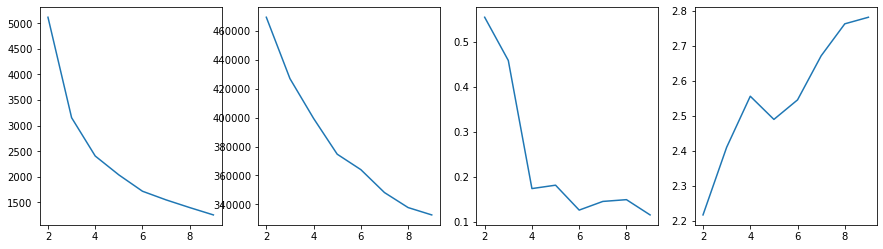

In [137]:
## check the trend of scores

## from SC and GS, k=4

scores_df = pd.DataFrame([inertia, CH, SC, GS]).T
scores_df.columns = ['inertia', 'CH', 'SC', 'GS']
scores_df.index = range(2,10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,4))
scores_df['CH'].plot(kind='line', ax=ax1)
scores_df['inertia'].plot(kind='line', ax=ax2)
scores_df['SC'].plot(kind='line', ax=ax3)
scores_df['GS'].plot(kind='line', ax=ax4)

<left style="font-size:12px;font-style:default;"><b>Figure N.n Validation Scores (a) Calinski-Harabasz Index, (b) Inertia, (c) Silhouette Coefficient, (d) Gap Statistic </b></left>

*Singular Value Decomposition for Plotting*

In [138]:
## Plot the clusters
## transform data into 2d using truncated svd

X_trunc = (TruncatedSVD(n_components=2)
                    .fit_transform(X_reduced))
y_pred_list = []
for k in range(3, 7):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred_list.append(km.predict(X_reduced))

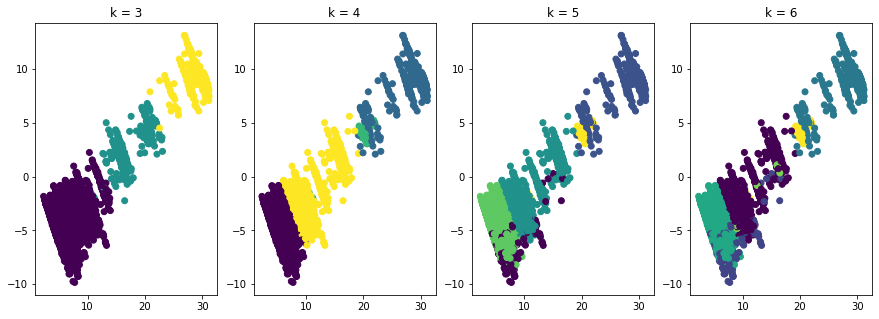

In [139]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax_list[i].scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[i])
    ax_list[i].set_title(f'k = {i+3}')

<left style="font-size:12px;font-style:default;"><b>Figure N.n KMeans Clustering Plot (SVD truncated at n=2) using k=3, 4, 5, 6</b></left>

**Analysis of Principal Components and Top Features**

Figure N.n shows the weight of the top features in the first 15 principal components. Notice that the PC-1, being the most important component, is more than 80% related to the feature `minimum_nights`. In addition, PC-2 is 50% explained by the same feature. This means that the feature `minimum_nights`is the most important feature. This can be confirmed by Figure N.n, showing the importance of each feature based on the result of KMeans clustering using k=4. 

The second most important feature is the price. The feature `log_price` consitutes 50% of PC-2. However, from Figure N.n., there is a large difference in the  importance between `log_price` and `minimum_nights`, i.e. 15% vs 85%. This means that more than 80% of the attributed of the clusterters is explained by their difference in the number of minimum nights. 

The third most important feature is the `beds`. From the heatmap, this feature constitutes 30-0% of PC-9 and PC-10. 

In [93]:
i = np.identity(X.shape[1])
weights = pd.DataFrame(svd.transform(i), index=X.columns)
weights.columns = [f'PC-{i+1}' for i in weights.columns]
weights = weights.transform(np.abs).copy()

Text(0.5, 1.0, 'Feature Weights in Principal Components')

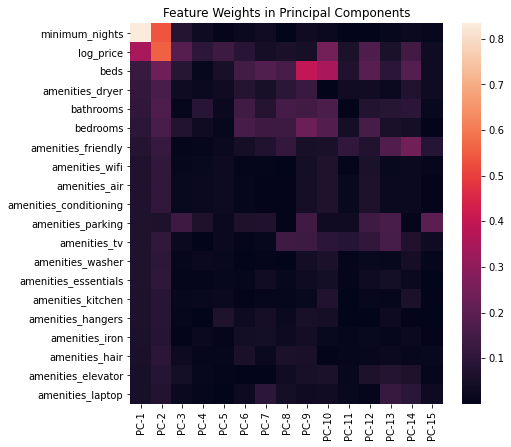

In [134]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.heatmap(weights.sort_values(by='PC-1', ascending=False).iloc[:20, :15], ax=ax)
ax.set_title('Feature Weights in Top 15 Principal Components')

<left style="font-size:12px;font-style:default;"><b>Figure N.n Absolute Weights of Top Features in the Top 15 Principal Components </b></left>

In [135]:
## rank features according to importance

km = KMeans(n_clusters=4, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
scores_list_bestk = []
bestk = SelectKBest(score_func=mutual_info_classif, k='all')
bestk.fit(X_reduced, km.predict(X_reduced))
scores_list_bestk.append(bestk.scores_)

Text(0.5, 1.0, 'Top 20 Features')

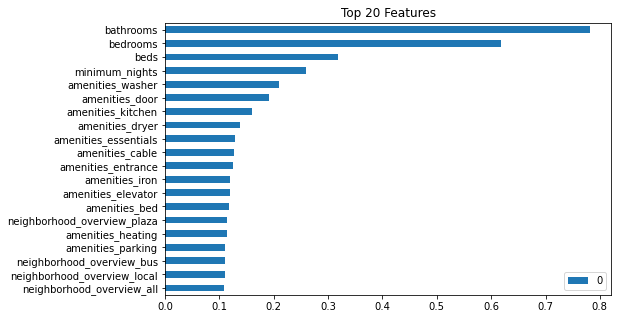

In [154]:
feature_rank_df = pd.DataFrame(scores_list_bestk)
feature_rank_df.columns = np.array(X.columns)[sel.get_support()]
feature_rank_df.T.sort_values(by=0)[-20:].plot(kind='barh', figsize=(8,5))
plt.title('Top 20 Features')

<left style="font-size:12px;font-style:default;"><b>Figure N.n Features Importance Ranking from KMeans</b></left>

In [162]:
## Top 10 Features
feature_rank_df.T.sort_values(by=0, ascending=False).index.to_list()[:25]

['bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'amenities_washer',
 'amenities_door',
 'amenities_kitchen',
 'amenities_dryer',
 'amenities_essentials',
 'amenities_cable',
 'amenities_entrance',
 'amenities_iron',
 'amenities_elevator',
 'amenities_bed',
 'neighborhood_overview_plaza',
 'amenities_heating',
 'amenities_parking',
 'neighborhood_overview_bus',
 'neighborhood_overview_local',
 'neighborhood_overview_all',
 'amenities_tv',
 'amenities_hair',
 'neighborhood_overview_apartment',
 'neighborhood_overview_convenient',
 'neighborhood_overview_if']

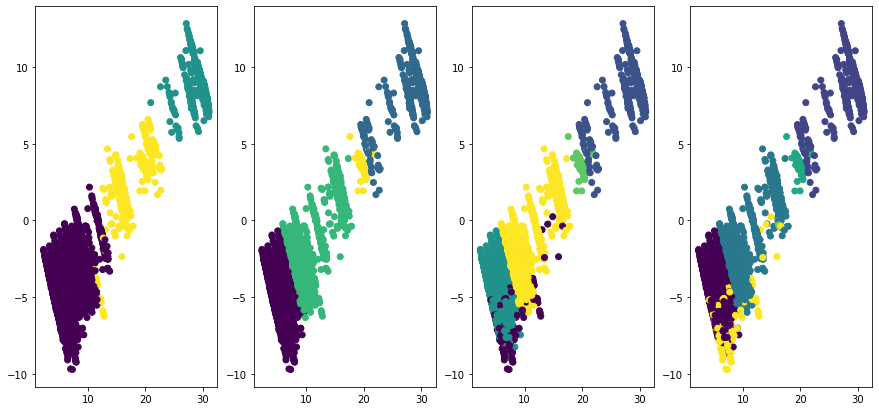

In [156]:
y_pred_list_agg = []
for k in range(3, 7):
    agc = AgglomerativeClustering(n_clusters=k, linkage='average').fit_predict(X_reduced)
    y_pred_list.append(agc)

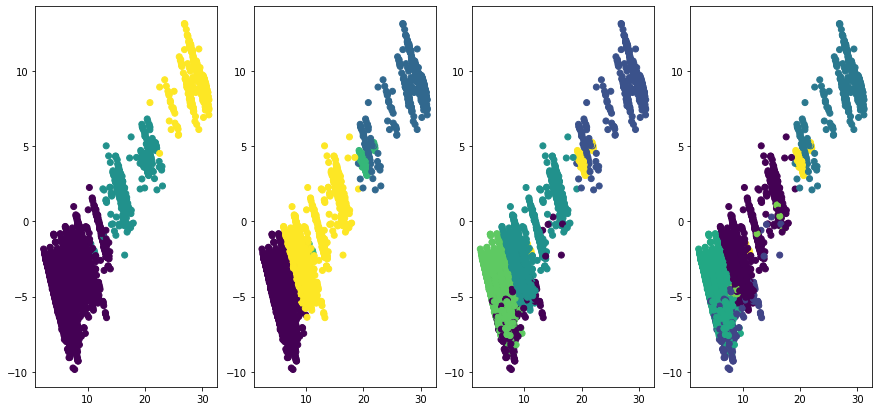

In [157]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 7))
ax1.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[0])
ax2.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[1])
ax3.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[2])
ax4.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[3])

## 8 Cluster Analysis and Exploration

In [158]:
## exploring the customer segments

predicted_data = data2.copy()
predicted_data['segment'] = y_pred_list[1]
predicted_data['price'] = predicted_data['log_price'].apply(lambda x: np.exp(x)-1)

segment_0 = predicted_data[predicted_data['segment']==0]
segment_1 = predicted_data[predicted_data['segment']==1]
segment_2 = predicted_data[predicted_data['segment']==2]
segment_3 = predicted_data[predicted_data['segment']==3]

**What Segments are For Over-Night Stays?**

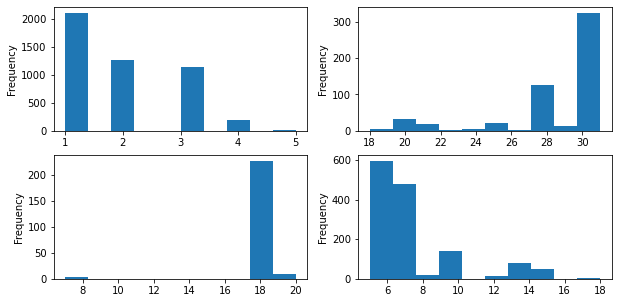

In [159]:
## explore differences in minimum nights of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    predicted_data[predicted_data['segment']==i]['minimum_nights'].plot(kind='hist', ax=ax_list[i])

**What Segments are Budget-Friendly? Luxury?**

Explain here the this segment is for economy. This one is for luxury, etc.

segment
0    140.771945
1    176.123845
2     49.218487
3    161.421739
Name: price, dtype: float64

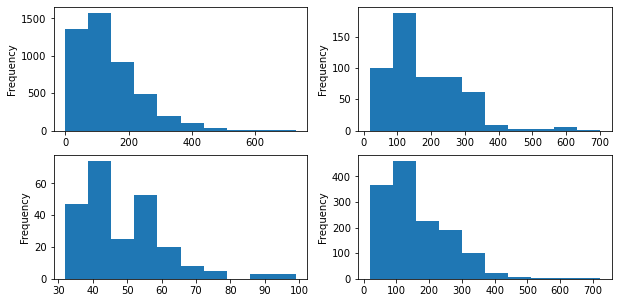

In [160]:
## explore price differences of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    predicted_data[predicted_data['segment']==i]['price'].plot(kind='hist', ax=ax_list[i])
    
predicted_data.groupby('segment')['price'].mean()

<a id="table2"></a> 
<left style="font-size:12px;font-style:default;"><b>Figure N.n Price Distribution at Different Segments</b></left>

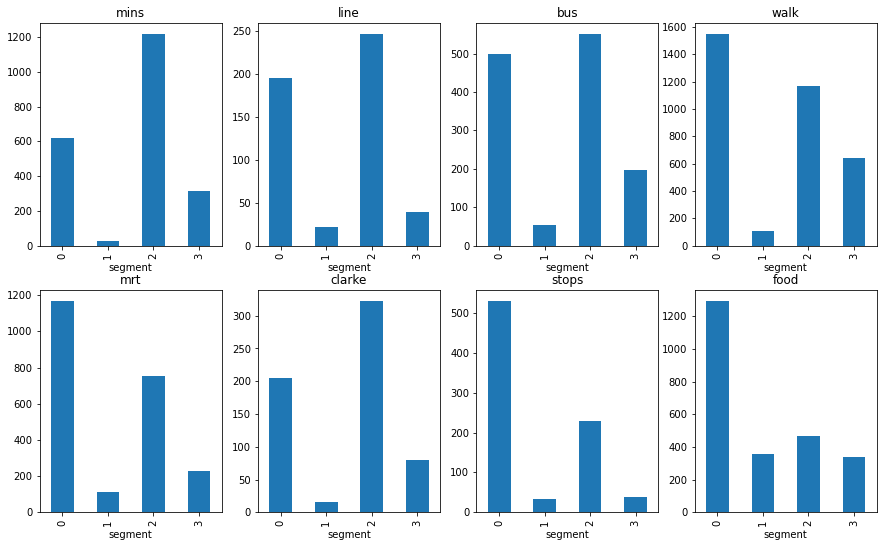

In [161]:
## explore differences in neighborhood overview at different segments
neighborhood = ['neighborhood_overview_mins', 'neighborhood_overview_line',
 'neighborhood_overview_bus',
 'neighborhood_overview_walk',
 'neighborhood_overview_mrt', 'neighborhood_overview_clarke', 
                'neighborhood_overview_stops', 'neighborhood_overview_food']

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,9))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(neighborhood)):
    predicted_data.groupby('segment')[neighborhood[i]].sum().plot(kind='bar', ax=ax_list[i])
#     ax_list[i].set_xlabel(rotation='horizontal')
    ax_list[i].set_title(neighborhood[i].split('_')[-1])

**Which Amenities are Most-Sought After?**

Explain here that these are the most sought after aminities.

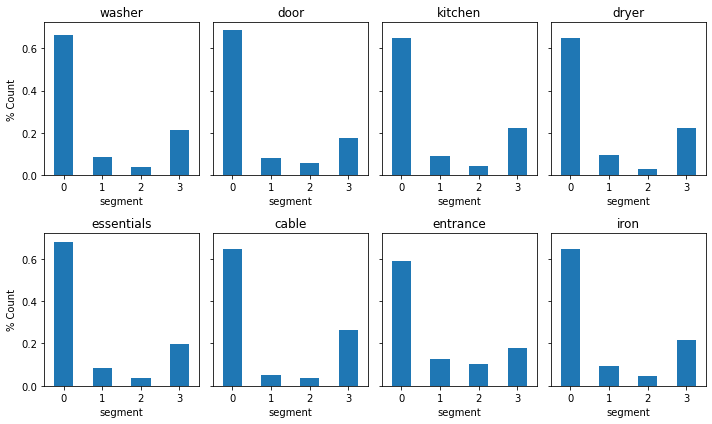

In [193]:
## explore differences in amenities at different segments

amenities = ['amenities_washer',
 'amenities_door',
 'amenities_kitchen',
 'amenities_dryer',
 'amenities_essentials',
 'amenities_cable',
 'amenities_entrance',
 'amenities_iron']
             
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(10,6), sharey=True)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(amenities)):
    a = predicted_data.groupby('segment')[amenities[i]].sum()
    a.apply(lambda x: x/a.sum()).plot(kind='bar', ax=ax_list[i])
#     ax_list[i].set_xlabel(rotation='horizontal')
    ax_list[i].set_title(amenities[i].split('_')[-1])
    ax_list[i].set_xticklabels(range(0,4), rotation='horizontal')
    ax_list[i].set(ylabel='% Count')
plt.tight_layout()

<a id="table2"></a> 
<left style="font-size:12px;font-style:default;"><b>Figure N.n Count of Amenities at Different Segments</b></left>

## 9 Conclusion

In this study, we applied unsupervised clustering of Singapore Air BnB listings using both KMeans and Agglomerative Cluctering. The best k selected was k=4 as indicated by Silhouette Coefficient and Gap Statistics trend lines. The Calinski Harabasz and Inertia trend lines did not sinificantly show the optimal k. Nonethless, the 2D plot of SVD truncated data showed that clusters are indeed most defined and logically representeted at k=4. 

## 10 Recommendation

## 11 Bibliography

[B] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/ <br>
[B] https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [1]:
raw

NameError: name 'raw' is not defined